In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft

# Define global variables
selected_point = None
old_frame = None
motion_history = []
time_history = []

# Mouse callback function to select a point
def select_point(event, x, y, flags, param):
    global selected_point
    if event == cv2.EVENT_LBUTTONDOWN:
        selected_point = (x, y)
    

# Create a VideoCapture object to capture video from your webcam
cap = cv2.VideoCapture('Untitled design.mp4')

# Define the CLAHE (Contrast Limited Adaptive Histogram Equalization) object
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
# Create a named window and set the mouse callback function
cv2.namedWindow('Optical Flow')
cv2.setMouseCallback('Optical Flow', select_point)

# Lucas-Kanade optical flow parameters
lk_params = dict(
    winSize=(15, 30),
    maxLevel=10,
    criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.02),
)

# Get the frame rate (frames per second) and total number of frames in the video
frame_rate = int(cap.get(cv2.CAP_PROP_FPS))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
z = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert the frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # Apply CLAHE to the grayscale frame
    gray = clahe.apply(gray)
    gray = cv2.GaussianBlur(gray,(5,5), 1)
    if selected_point is not None:
        # Calculate optical flow
        p1, st, err = cv2.calcOpticalFlowPyrLK(
            old_frame, gray, np.array([selected_point], dtype=np.float32), None, **lk_params
        )
        
        if st[0][0] == 1:
            # Draw the point and the motion vector
            x, y = selected_point
            x_new, y_new = p1[0].astype(int)
            
            cv2.circle(gray, (x_new, y_new), 5, (0, 255, 0), -1)
            cv2.circle(gray, (x, y), 5, (0, 0, 225), -1)
            #cv2.line(frame, (x, y), (x_new, y_new), (0, 0, 255), 2)

            # Calculate displacement from the initial position
            displacement = (x_new, y_new)

            # Append the displacement to the motion_history
            motion_history.append(displacement)
            time_history.append(z / frame_rate)

    cv2.imshow('Optical Flow', gray)
    old_frame = gray

    key = cv2.waitKey(1) & 0xFF
    if key == 27:  # Press 'Esc' to exit
        break

    z = z + 1

# Release the VideoCapture and close all windows
cap.release()
cv2.destroyAllWindows()

# Convert motion history to a numpy array
motion_history = np.array(motion_history)

# Subtract the initial position from all coordinates in motion history
initial_position = selected_point[0]
initial_positiony = selected_point[1]
print(initial_position)
motion_history[:,0] -= initial_position
motion_history[:,1] -= initial_positiony
# Plot the motion history with time and subtracted coordinates

725


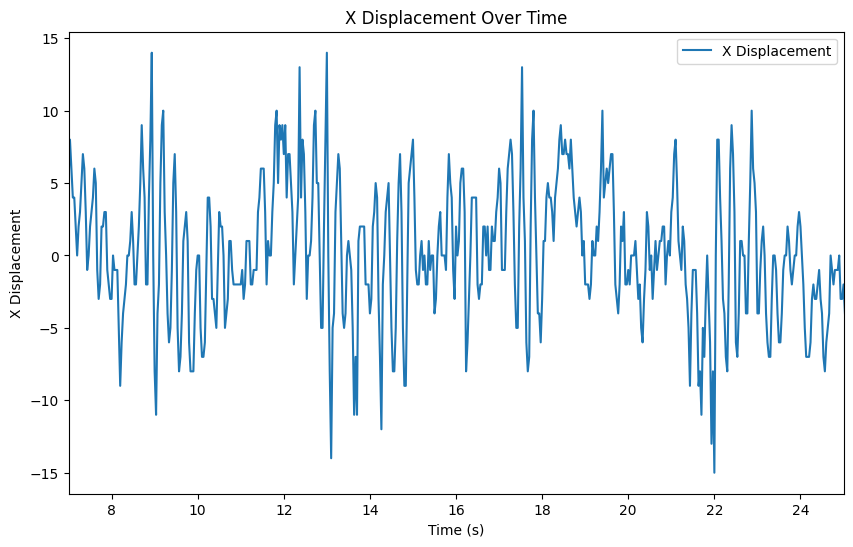

In [5]:
if motion_history.any():
    plt.figure(figsize=(10, 6))
    
    #plt.subplot(1, 2, 1)
    plt.plot(time_history, motion_history[:, 0], label='X Displacement')
    plt.xlim(7,25)
    plt.xlabel('Time (s)')
    plt.ylabel('X Displacement')
    plt.title('X Displacement Over Time')
    plt.legend()

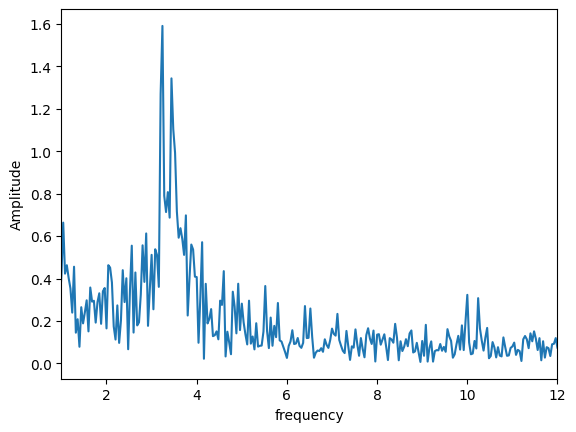

In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack
seconds=total_frames/frame_rate
# Number of samplepoints
N = len(motion_history)
# sample spacing
T = seconds/N
x = np.linspace(0.0, seconds, N)
y = motion_history[:, 0]
yf = scipy.fftpack.fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

fig, ax = plt.subplots()
ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
plt.xlim(1,12)
plt.ylabel('Amplitude')
plt.xlabel('frequency')
plt.show()